# Set up Environment and Load Data

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


In [3]:
combined = sc.read('/scratch/qc_filtered_combined_samples.h5ad')

# Normalization and Log-transformation

Before normalization, archive the raw data 

In [4]:
combined.raw = combined

In [5]:
# normalize to depth 10000
sc.pp.normalize_per_cell(combined, counts_per_cell_after=1e4)

# take log
sc.pp.log1p(combined)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


# Highly Variable Genes

Find highly variable features/genes that will also provide a good separation of the cell types and cell clusters.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 2102


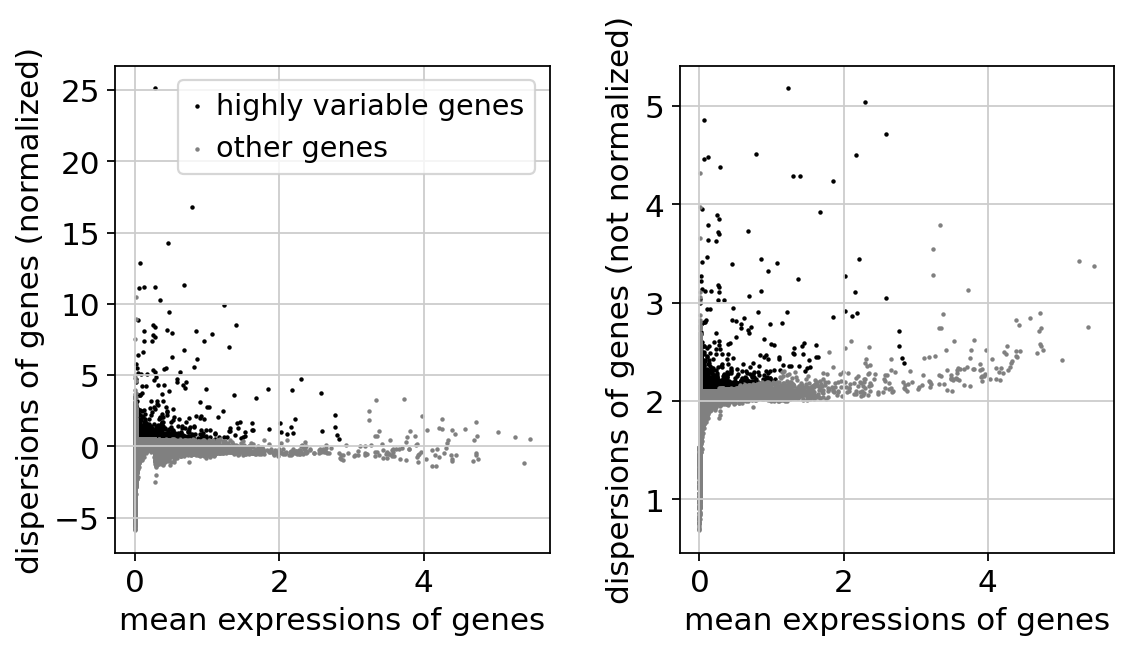

In [6]:
# compute variable genes
sc.pp.highly_variable_genes(combined, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: {}".format(sum(combined.var.highly_variable)))

# plot variable genes
sc.pl.highly_variable_genes(combined)

# Only include for variable genes in the dataset
combined = combined[:, combined.var['highly_variable']]

# Mean-centering and Scaling through Z-transformation

Since each gene has a different expression level, genes with higher expression level will naturally have higher variation that will be captured by PCA. This means that we need to somehow give each gene a similar weight when performing PCA (see below) to allow the variation in the genes with lower expression level to be captured. The common practice is to center and scale each gene before performing PCA. This exact scaling is called Z-score normalization it is very useful for PCA, clustering and plotting heatmaps. We also use regression to remove any unwanted sources of variation from the dataset, such as cell cycle, sequencing depth, percent mitocondria. This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the "regressed data". Although perhaps not in the best way, batch effect regression can also be done here.

In [7]:
# regress out unwanted variables
sc.pp.regress_out(combined, ['n_counts', 'percent_mito'])

# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(combined, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:32)


# PCA

In [8]:
sc.tl.pca(combined, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


## plot the data points projected onto principal components 

Plot by samples

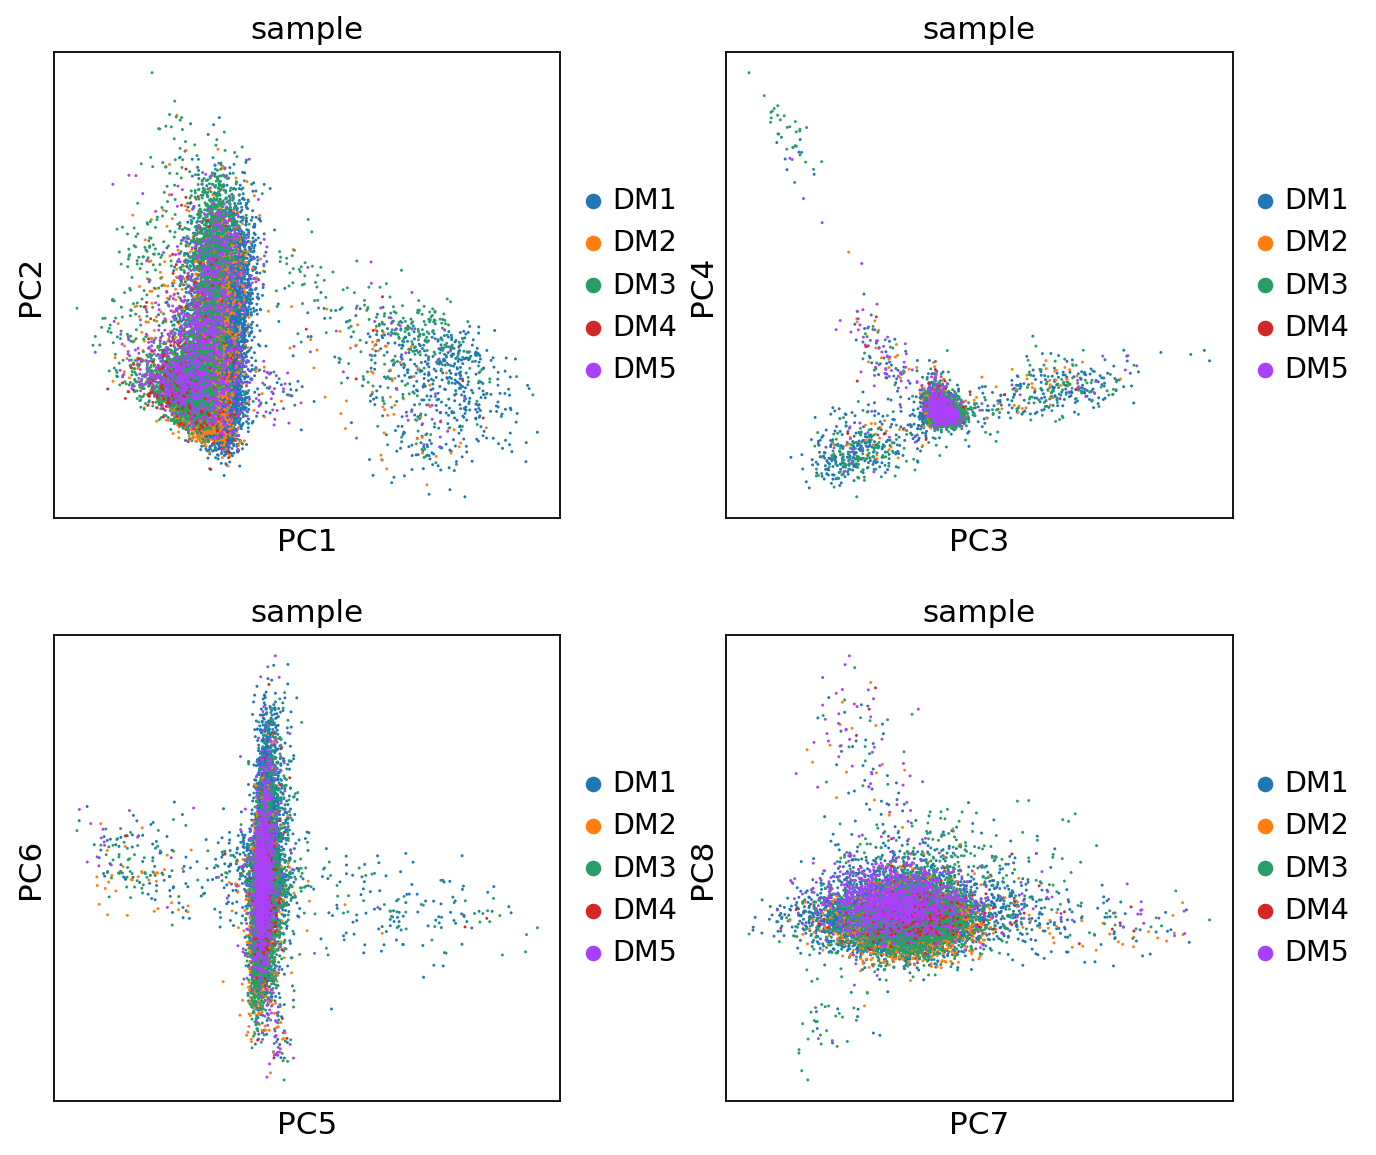

In [9]:
sc.pl.pca(combined, color='sample', components = ['1,2','3,4','5,6','7,8'], ncols=2)

Plot by user groups

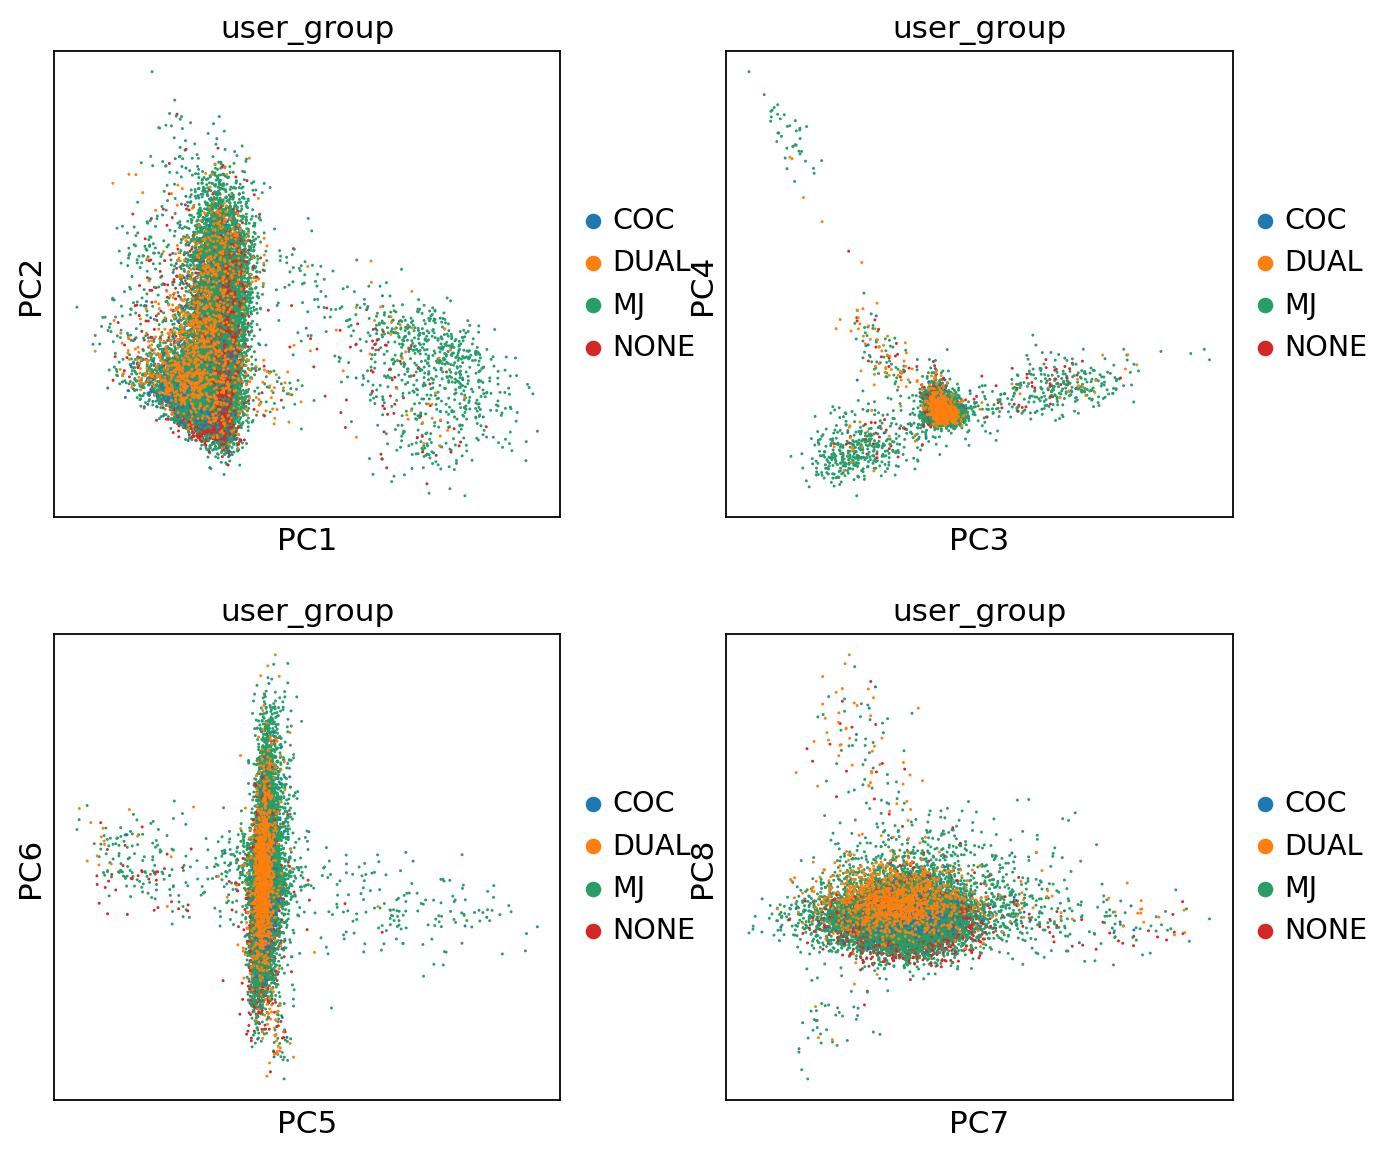

In [10]:
sc.pl.pca(combined, color='user_group', components = ['1,2','3,4','5,6','7,8'], ncols=2)

## Identify the pricipal components

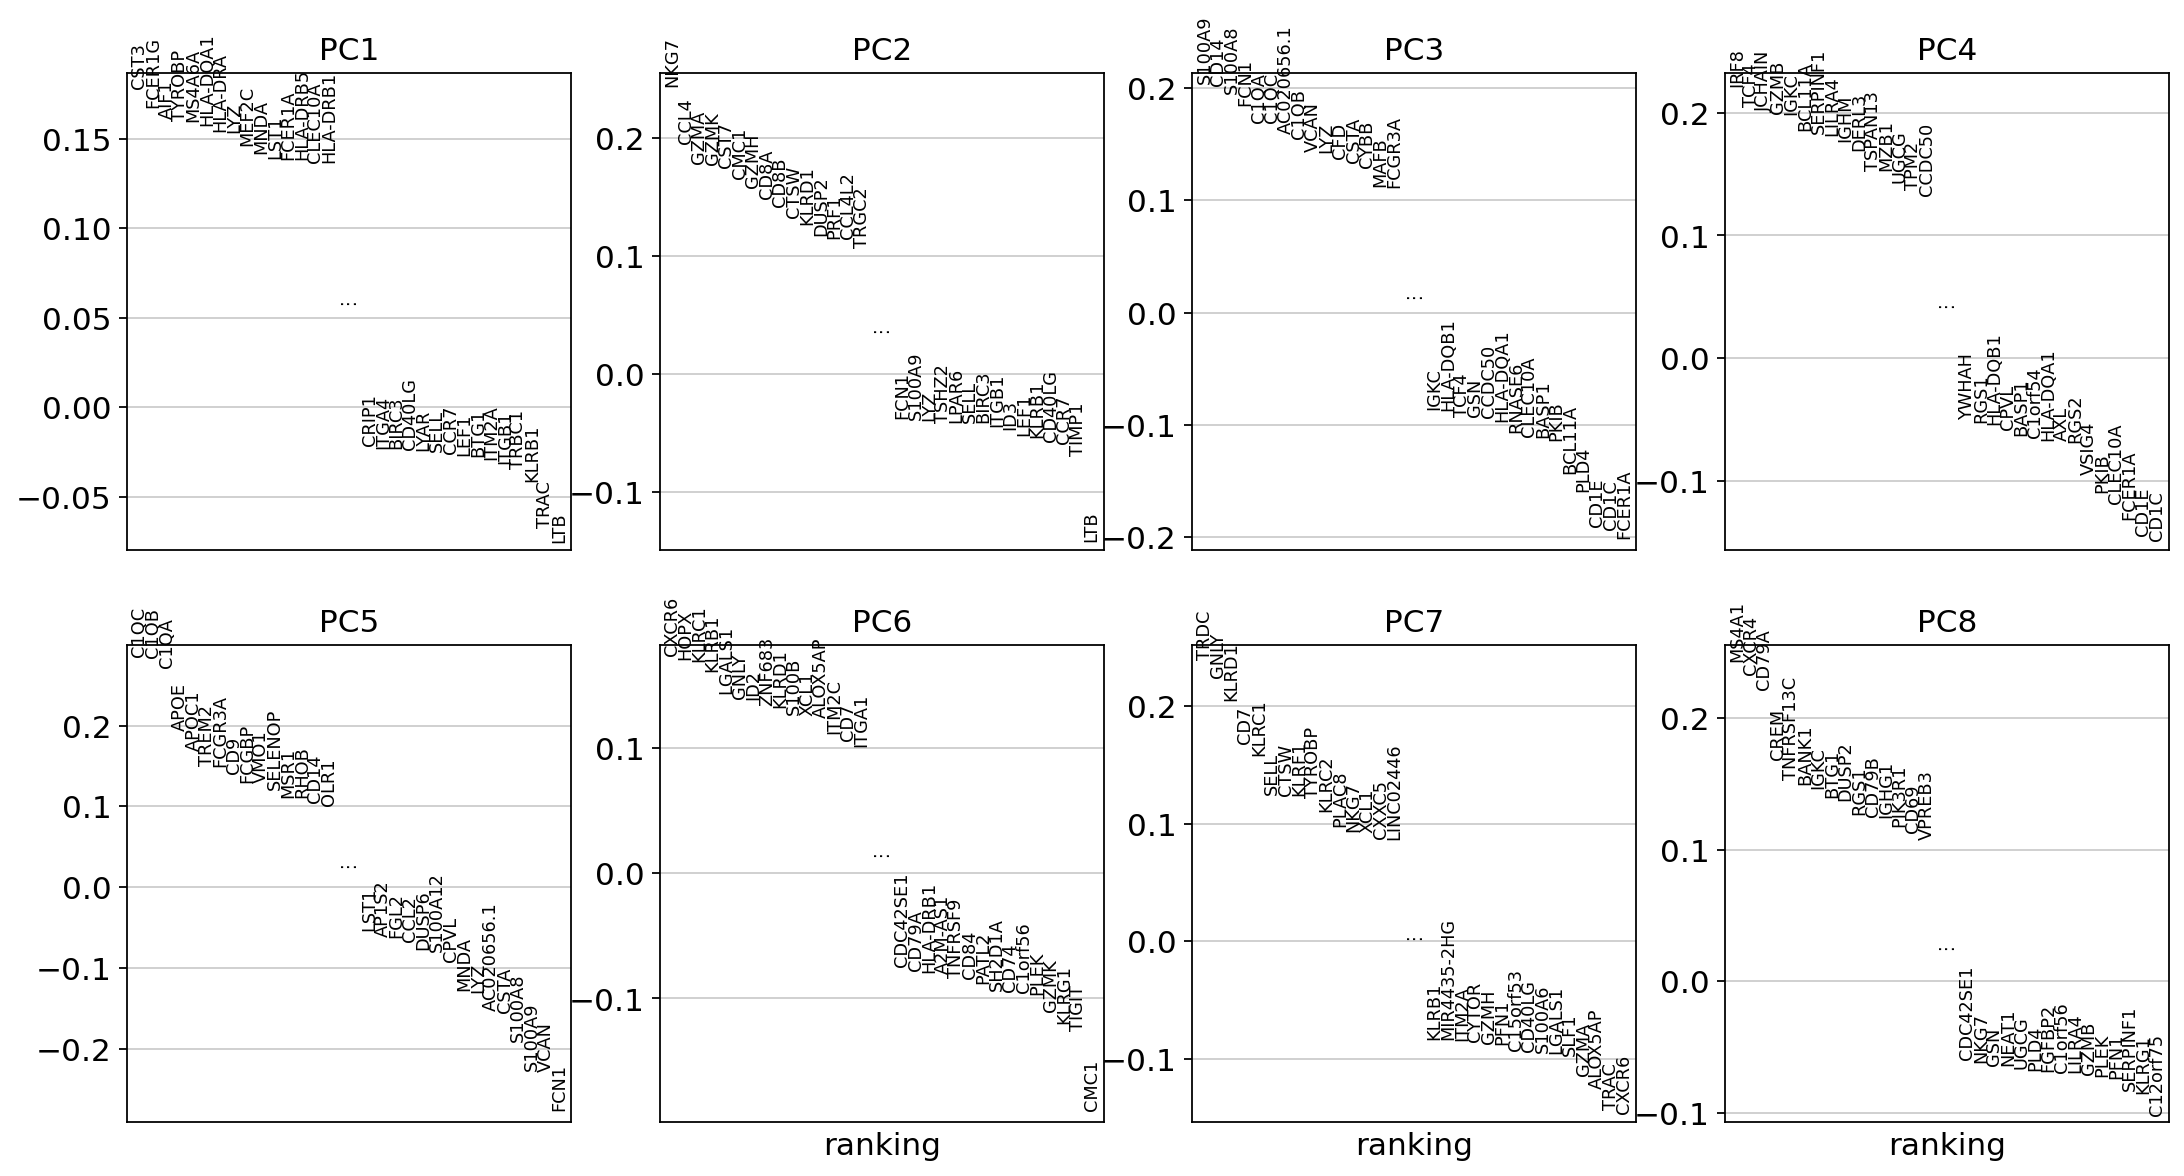

In [11]:
#Plot loadings
sc.pl.pca_loadings(combined, components=[1,2,3,4,5,6,7,8])

# OBS! only plots the positive axes genes from each PC!!

Plot the percent of variance explained by each PC, use the elbow point to decide the number of PC used for downstream TSNE and UMAP

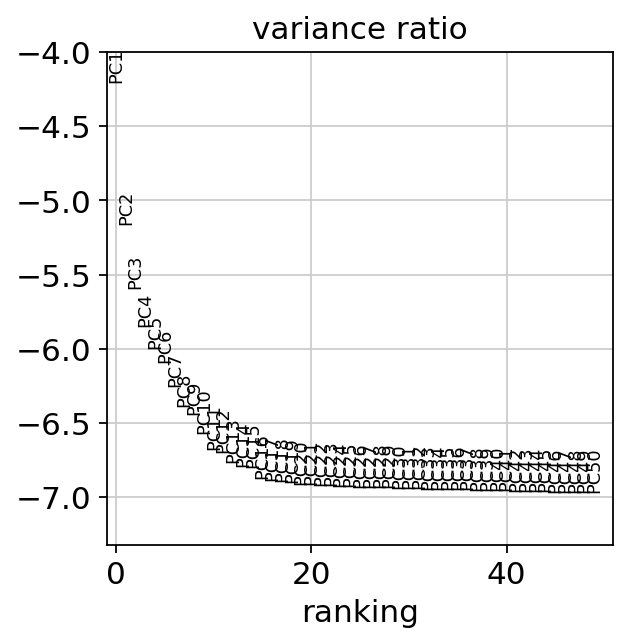

In [12]:
sc.pl.pca_variance_ratio(combined, log=True, n_pcs = 50)

It seems like 16 is a fair choice. 

# Dimension Reduction by Manifold Embedding

## TSNE 

Run TSNE with the initialization by the first 30 PC's

In [13]:
sc.tl.tsne(combined, n_pcs = 16)

computing tSNE
    using 'X_pca' with n_pcs = 16
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:38)


### TSNE plot by samples and by user groups

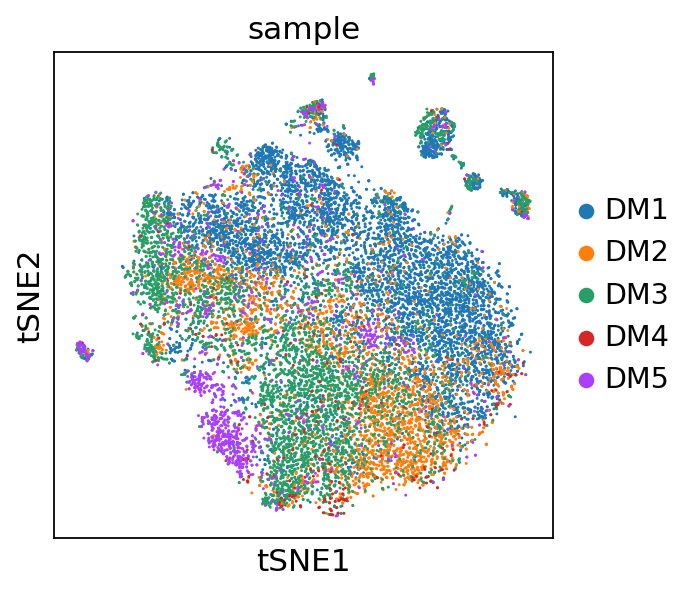

In [14]:
sc.pl.tsne(combined, color='sample')

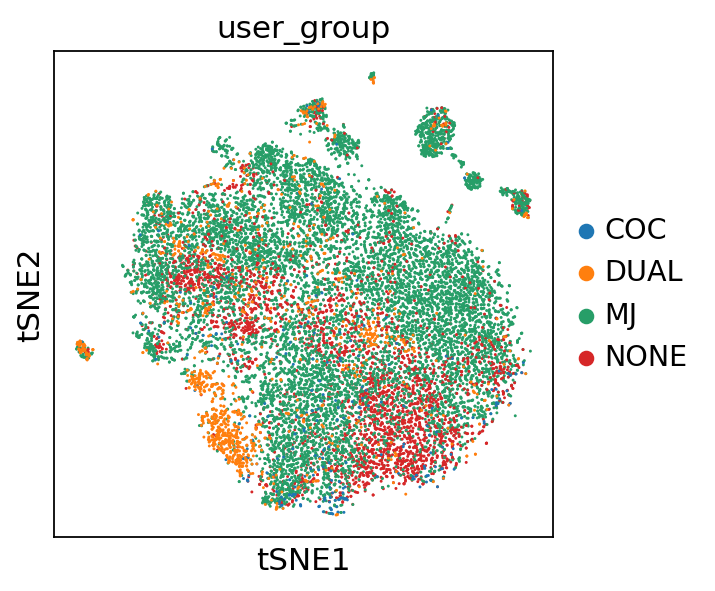

In [15]:
sc.pl.tsne(combined, color='user_group')

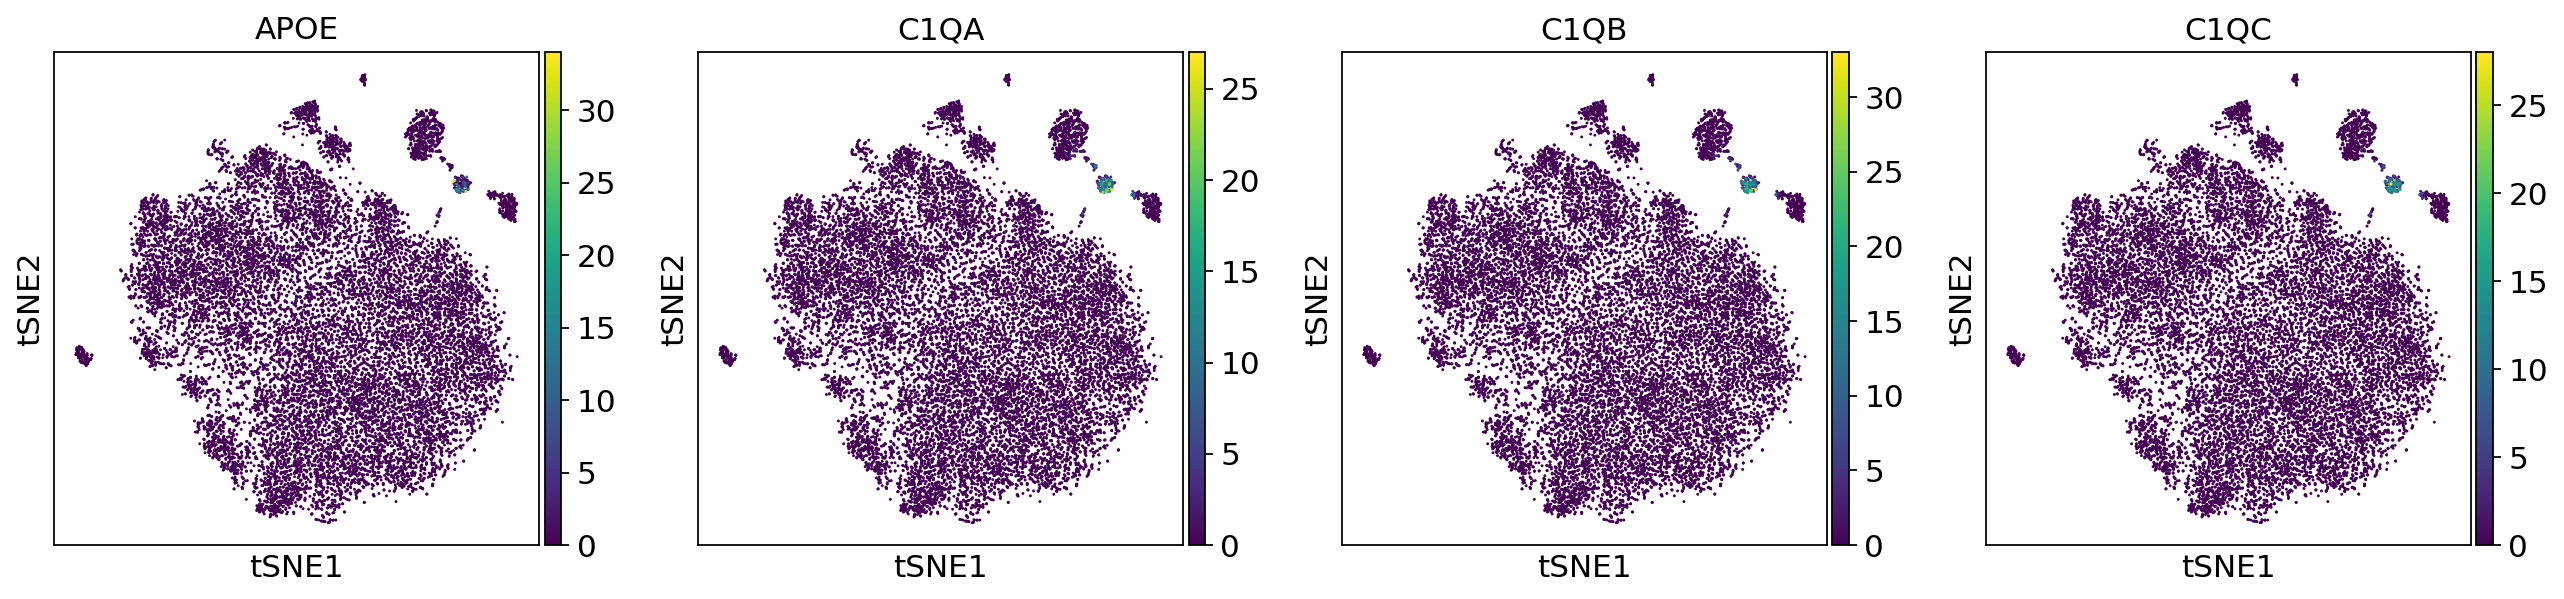

In [16]:
sc.pl.tsne(combined, color=["APOE","C1QA","C1QB","C1QC"])

## UMAP

Since UMAP is built on top of a neighborhood graph, we first compute that with the first 16 PC's. 

In [17]:
sc.pp.neighbors(combined, n_pcs = 16, n_neighbors = 20)

computing neighbors
    using 'X_pca' with n_pcs = 16
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


In general UMAP can project down to any dimension (TSNE is not able to do this), simply set n_components=10. Here we only use the default n_components=2.

In [18]:
# project to a 2-dimensional subspace, save to a new object so that the umap with 2D is not overwritten.
combined_umap = sc.tl.umap(combined, n_components=2, copy=True)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


### UMAP plot by samples and by groups

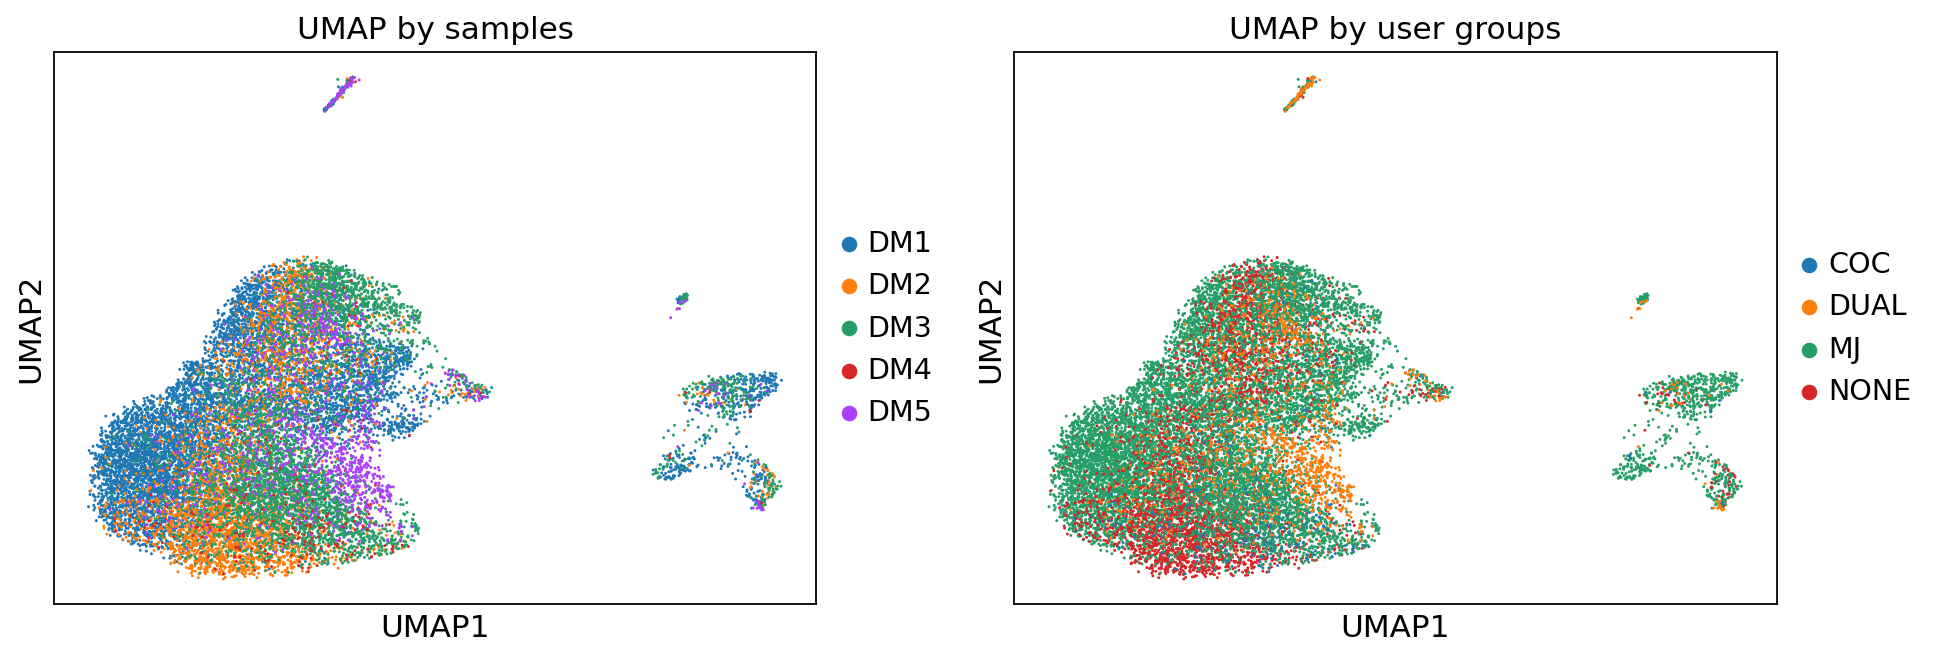

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,4),constrained_layout=True)
sc.pl.umap(combined_umap, color='sample',  title="UMAP by samples", show=False, ax=axs[0])
sc.pl.umap(combined_umap, color='user_group',  title="UMAP by user groups", show=False, ax=axs[1])

### Expression of genes of interest

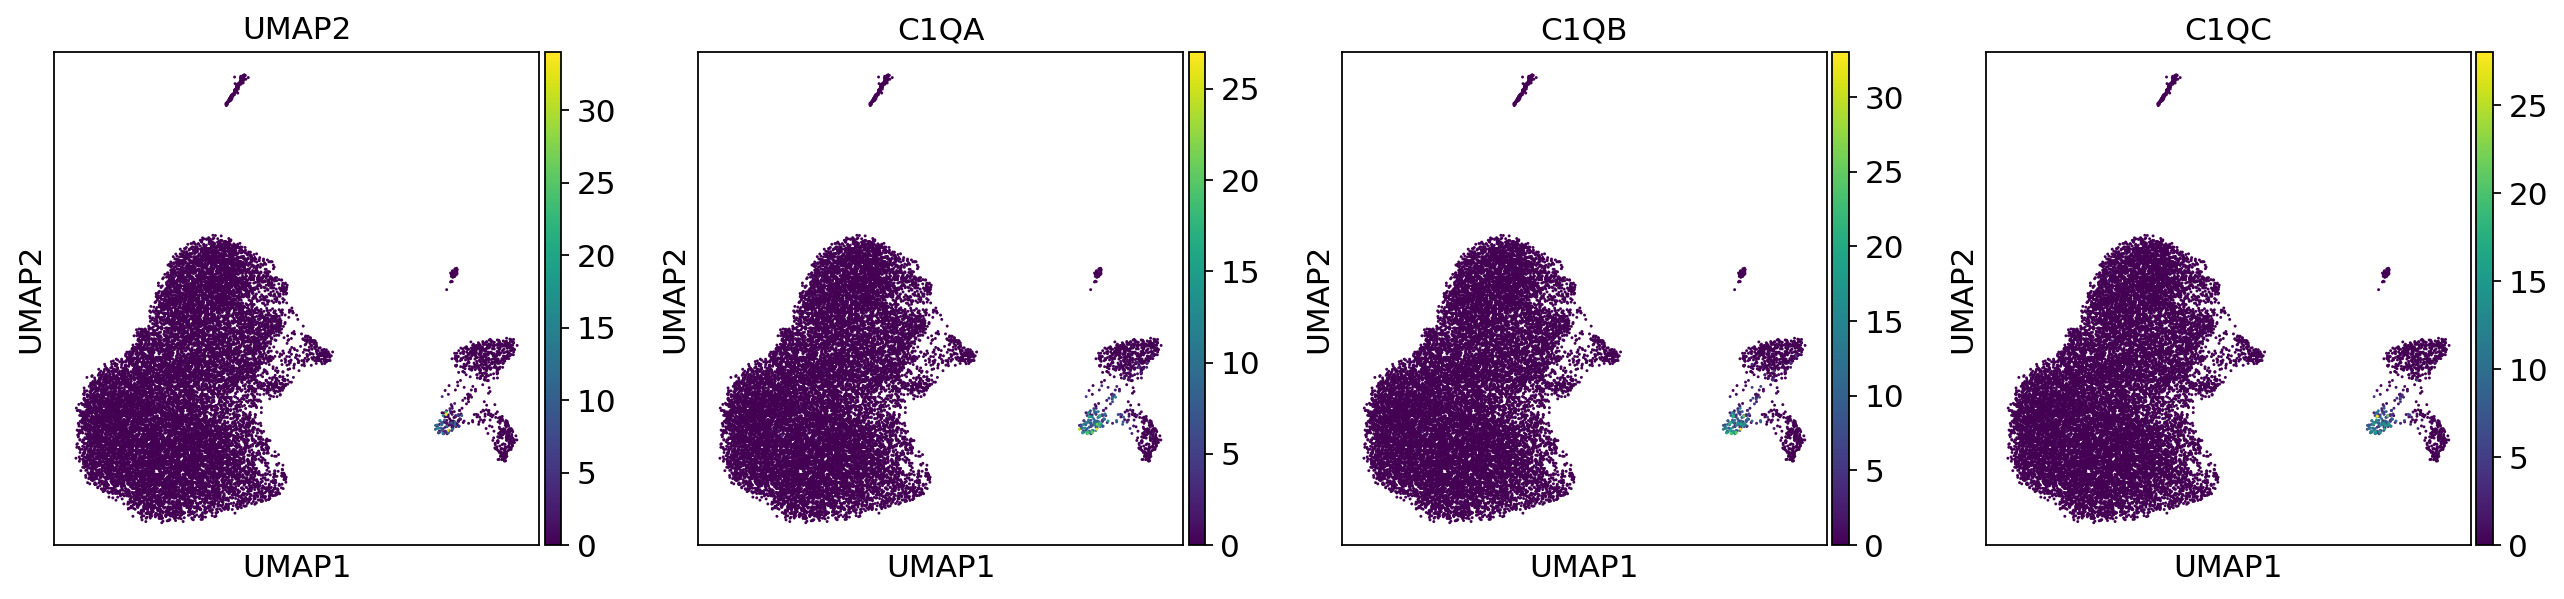

In [20]:
sc.pl.umap(combined_umap, color=["APOE","C1QA","C1QB","C1QC"], title='UMAP2')

All of the four genes are highly expressed in a small cluster near the right-bottom cornor, which corresponds to marijuana user group DM1 and DM3.

### Expression of other immune-related genes


Markers	Cell Type
CD3E: T cells

CD3E, CD4: CD4+ T cells

CD3E, CD8A: CD8+ T cells

GNLY, NKG7: NK cells

MS4A1: B cells

CD14, LYZ, CST3, MS4A7: CD14+ Monocytes

FCGR3A, LYZ, CST3, MS4A7: FCGR3A+ Monocytes

FCER1A, CST3: DCs

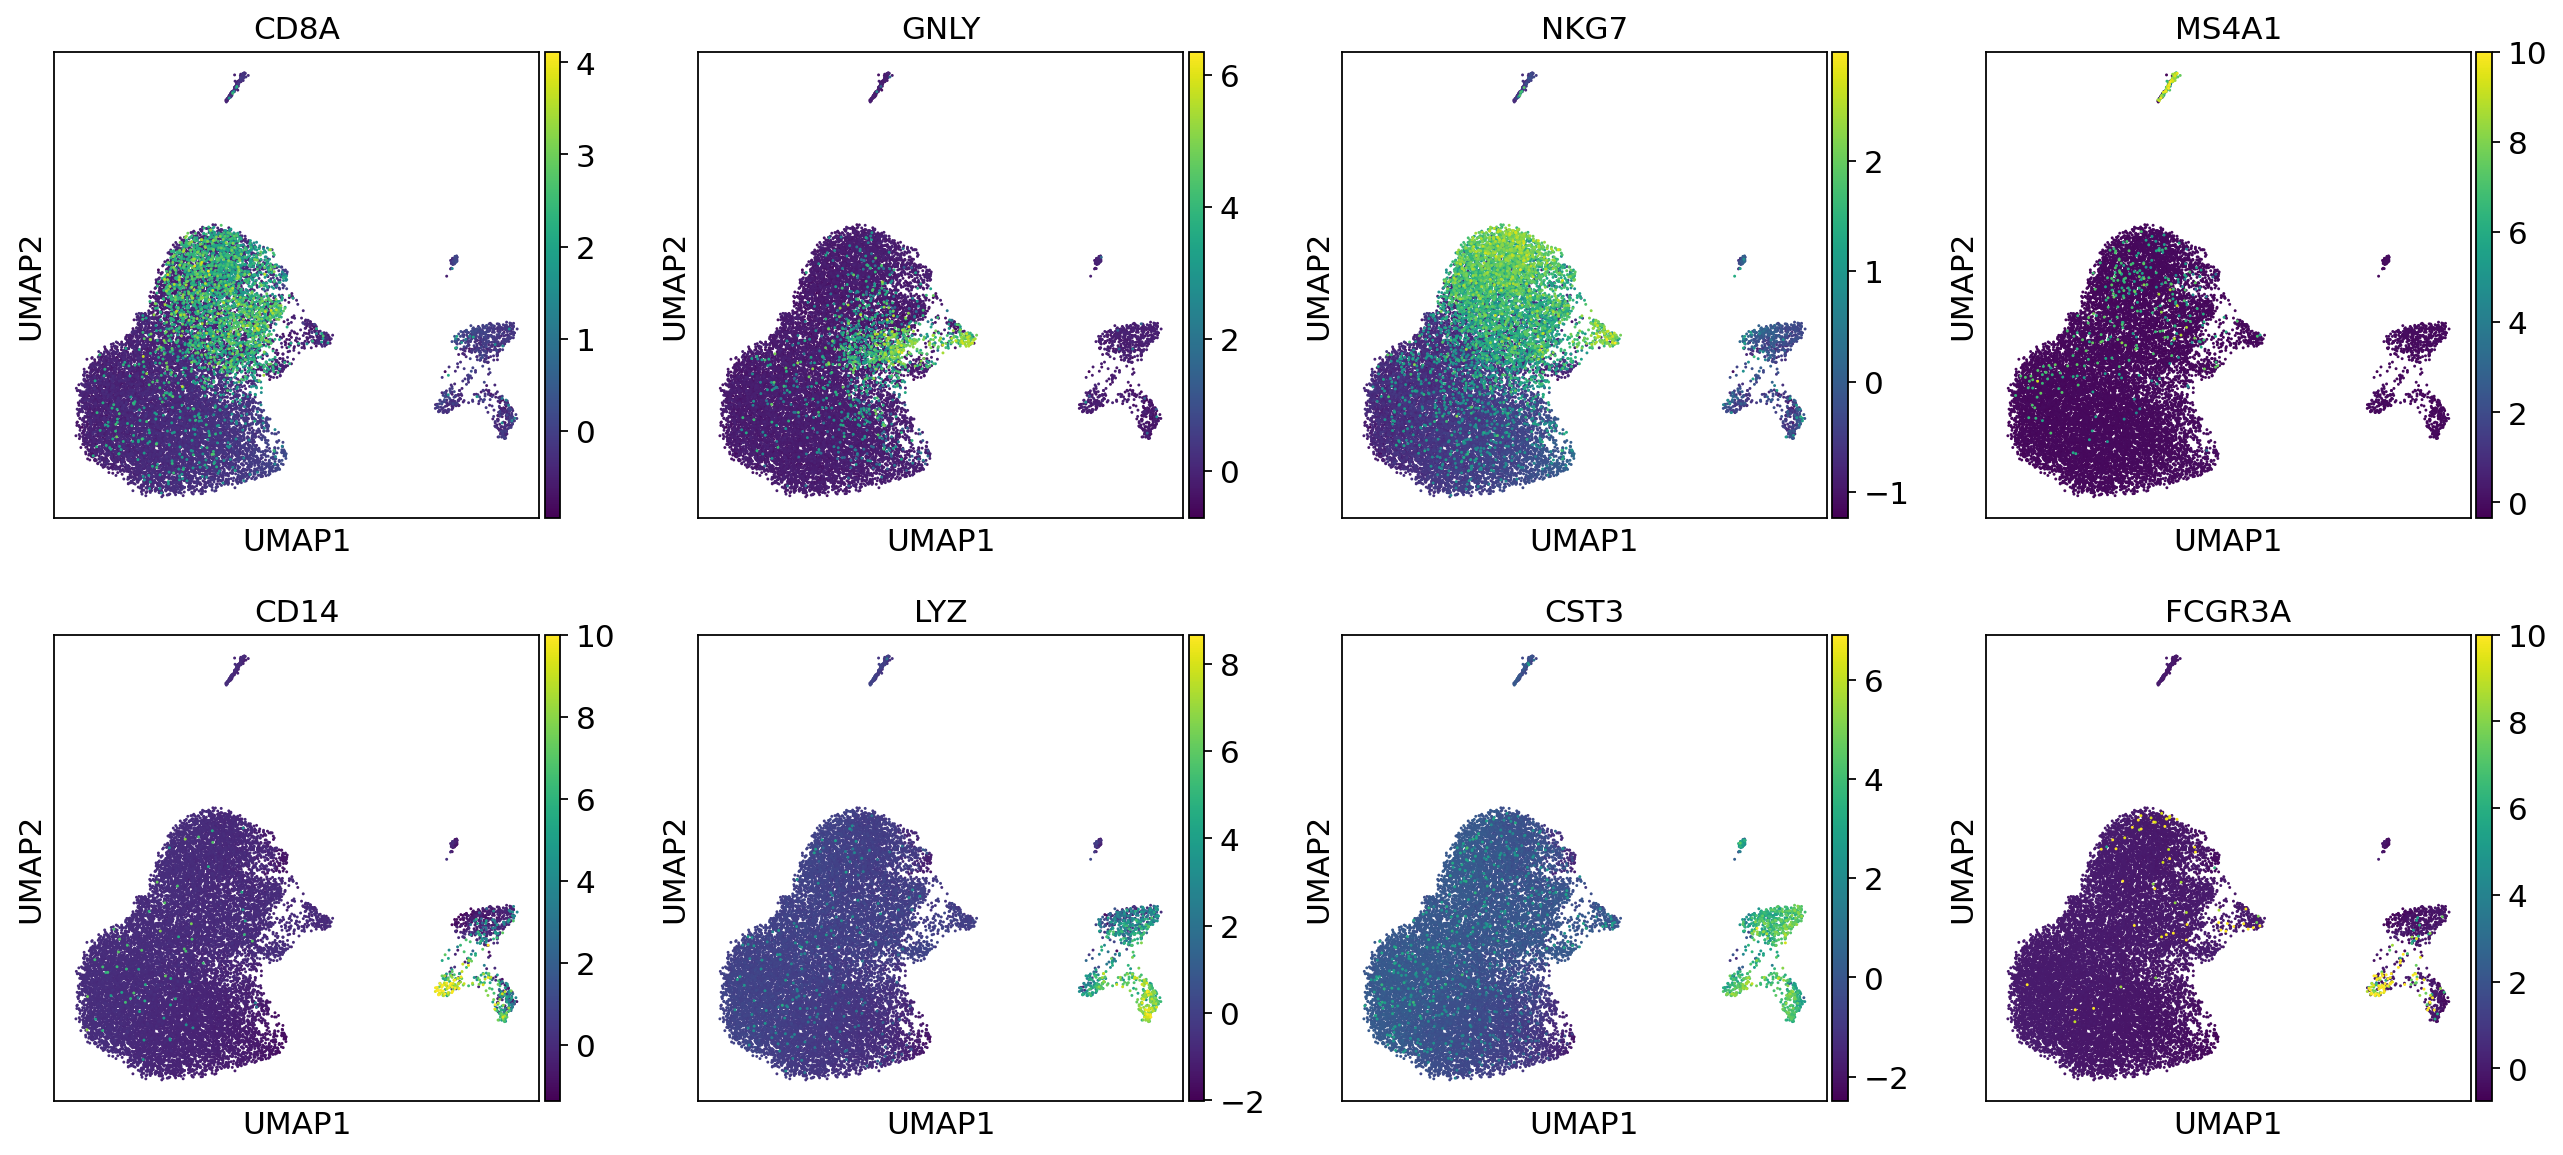

In [22]:
genes  = ["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"]
var_genes = combined_umap.var.highly_variable
var_genes.index[var_genes]
varg = [x for x in genes if x in var_genes.index[var_genes]]
sc.pl.umap(combined_umap, color=varg, use_raw=False)

### Plot by cell clusters by UMAP

In [23]:
sc.tl.louvain(combined_umap)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


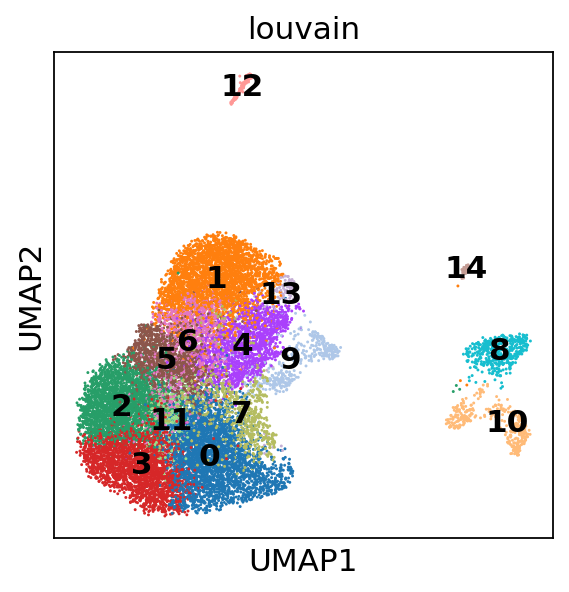

In [24]:
sc.pl.umap(combined_umap, color='louvain',legend_loc='on data')

### Find Marker Genes for UMAP Clusters

In [25]:
sc.tl.rank_genes_groups(combined_umap, groupby='louvain', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


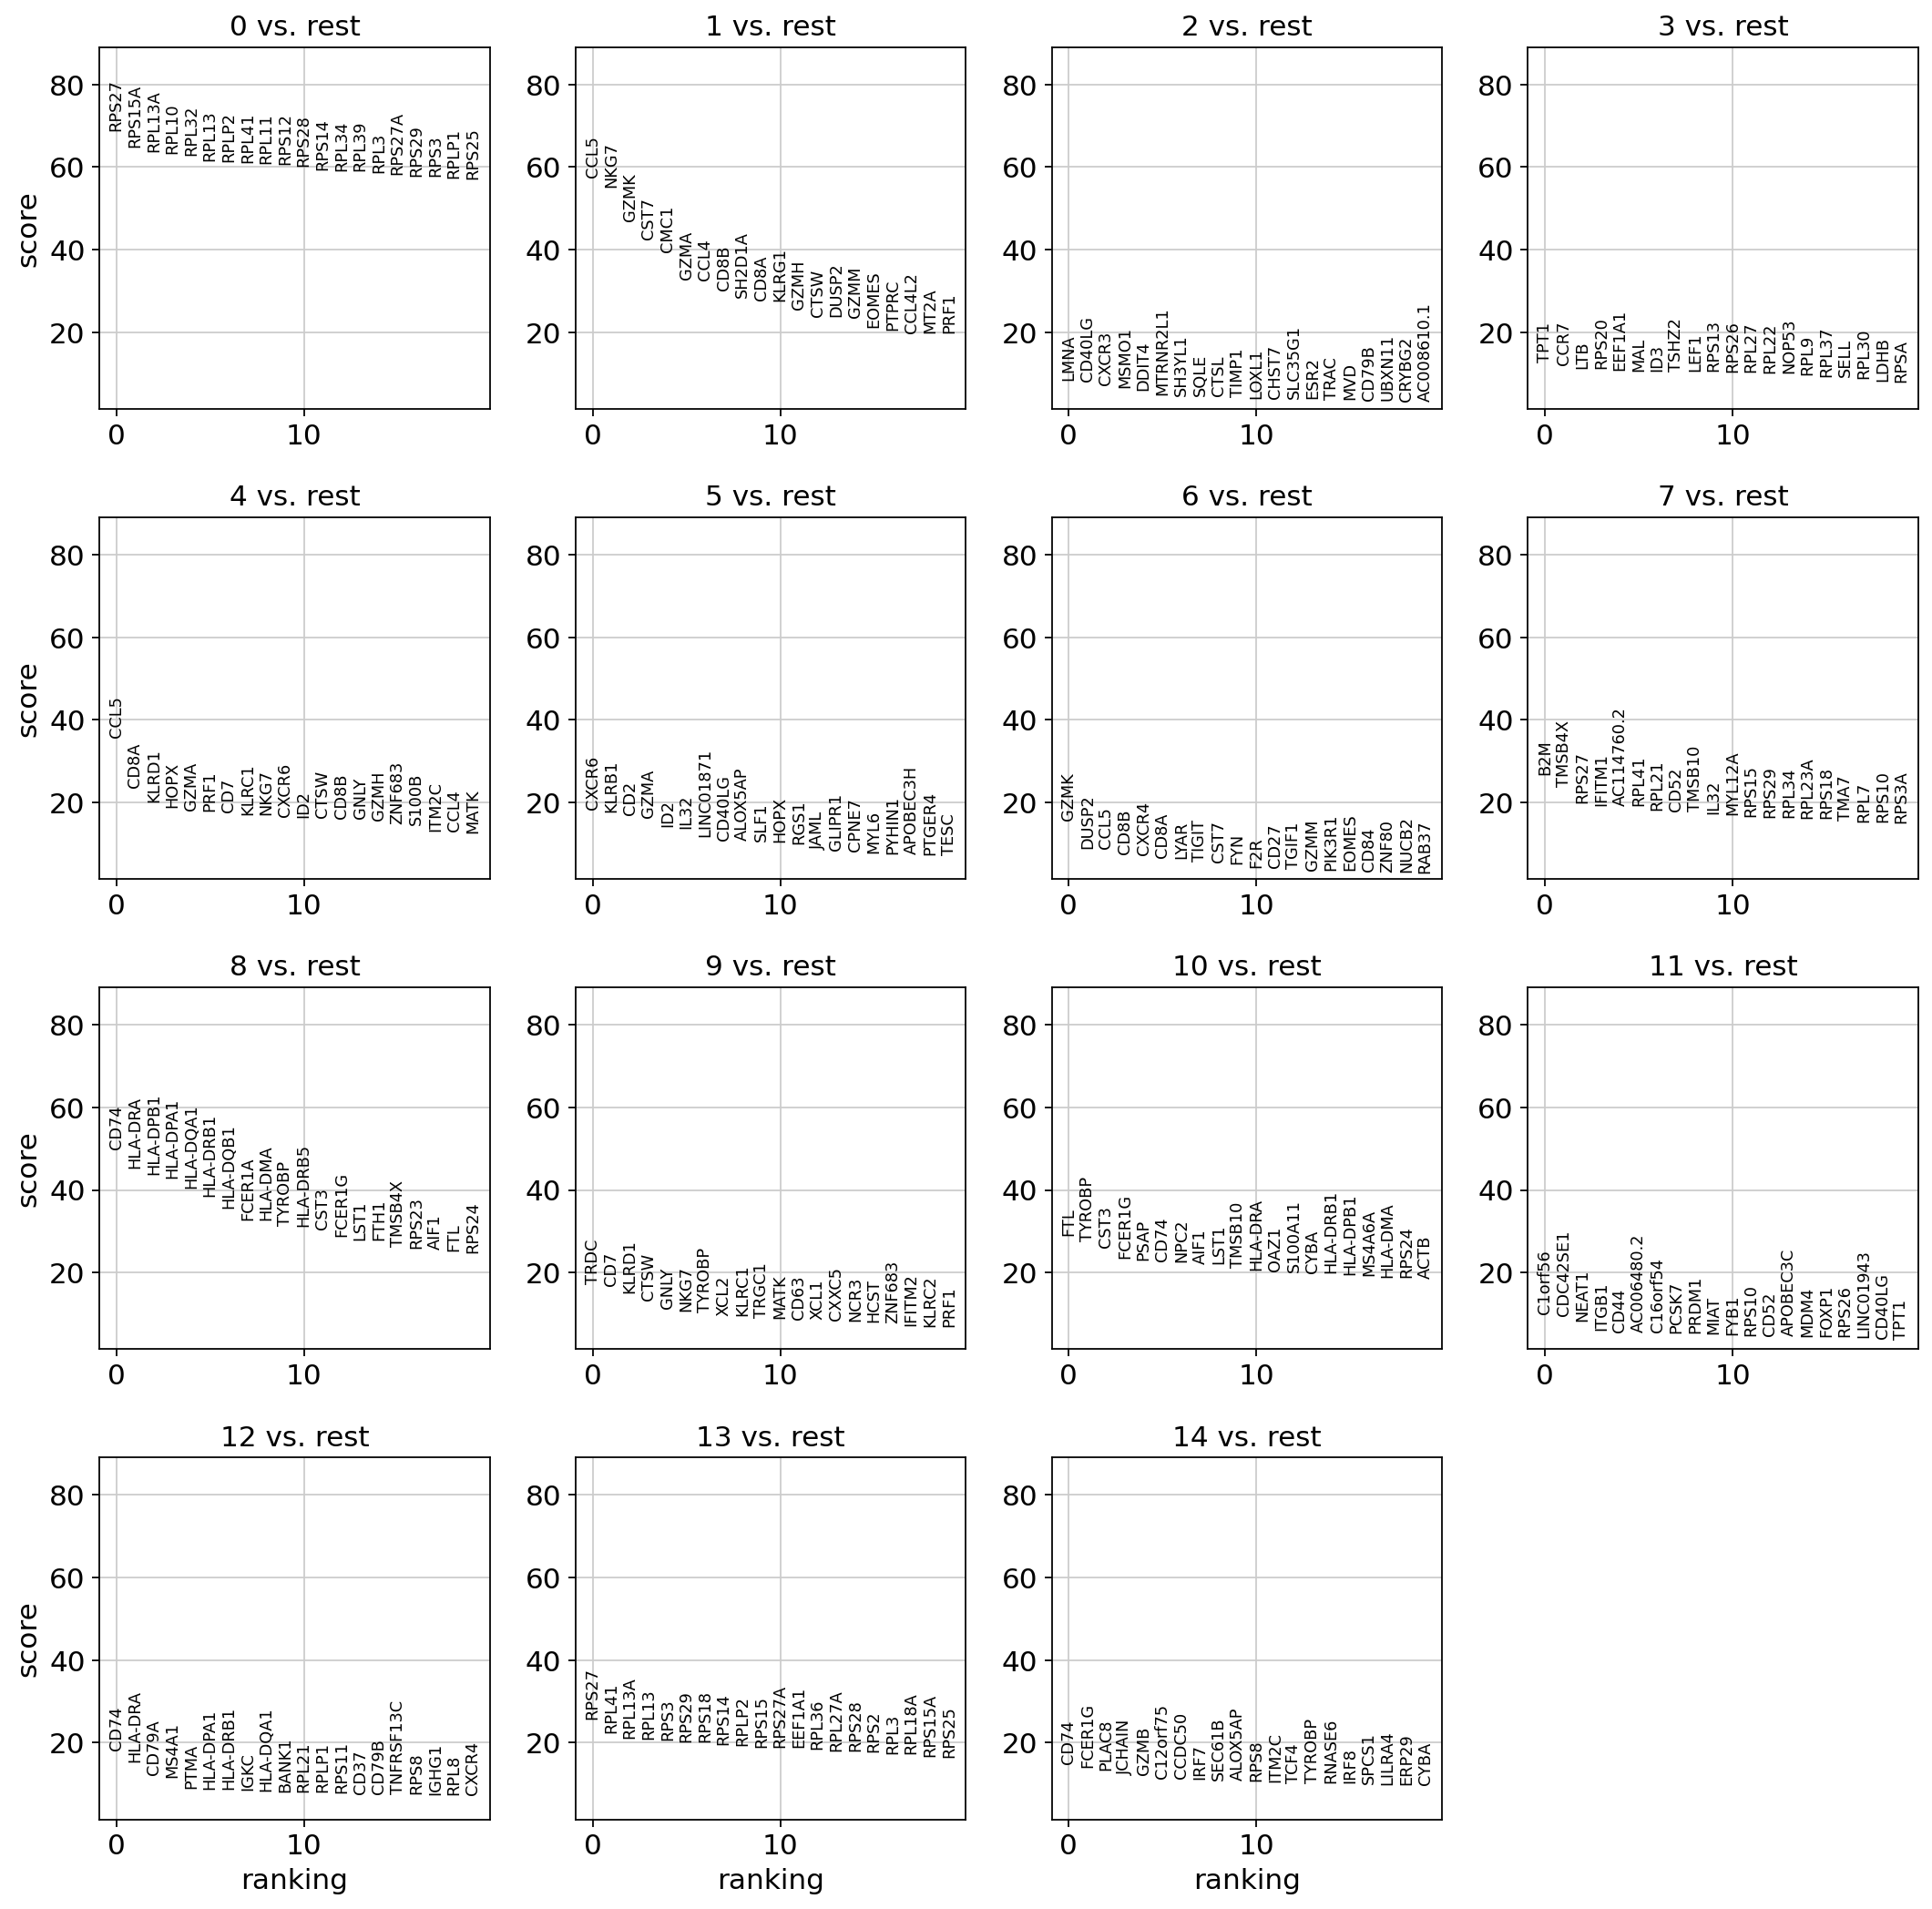

In [26]:
sc.pl.rank_genes_groups(combined_umap)

In [56]:
print("The tuples are ordered as (gene_names,log_fold_changes,adj_p_values)")
for i in range(15):
    print("Cluster {}:".format(i))
    print(tuple(zip((combined_umap.uns['rank_genes_groups']['names'][i][j] for j in range(5)),
                    (combined_umap.uns['rank_genes_groups']['logfoldchanges'][i][j] for j in range(5)),
                    (combined_umap.uns['rank_genes_groups']['pvals_adj'][i][j] for j in range(5)))))

The tuples are ordered as (gene_names,log_fold_changes,adj_p_values)
Cluster 0:
(('RPS27', 30.346766, 0.0), ('CCL5', 7.867453, 0.0), ('LMNA', 1.7885866, 5.081993524297355e-16), ('TPT1', 1.7976742, 3.244251565430438e-34), ('CCL5', 6.6762333, 3.0924605731519423e-208))
Cluster 1:
(('RPS15A', 16.1986, 0.0), ('NKG7', 5.221773, 0.0), ('CD40LG', 0.77114415, 2.990803559740355e-15), ('CCR7', 1.3155574, 4.785285885999527e-31), ('CD8A', 2.4730473, 8.354307833659219e-105))
Cluster 2:
(('RPL13A', 18.850143, 0.0), ('GZMK', 3.618621, 0.0), ('CXCR3', 0.58589196, 9.319242439643282e-12), ('LTB', 1.0651747, 2.582021901741805e-27), ('KLRD1', 2.7914643, 2.0131971339151584e-78))
Cluster 3:
(('RPL10', 25.090937, 0.0), ('CST7', 2.8383162, 1.698807521787e-312), ('MSMO1', 0.73910296, 4.152291955154661e-10), ('RPS20', 1.281, 4.756638916424006e-27), ('HOPX', 1.9158756, 1.5594507587146735e-69))
Cluster 4:
(('RPL32', 16.07702, 0.0), ('CMC1', 5.0727825, 5.431241892549601e-272), ('DDIT4', 0.56918097, 2.95902187703533

### Plot by cell clusters by TSNE

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


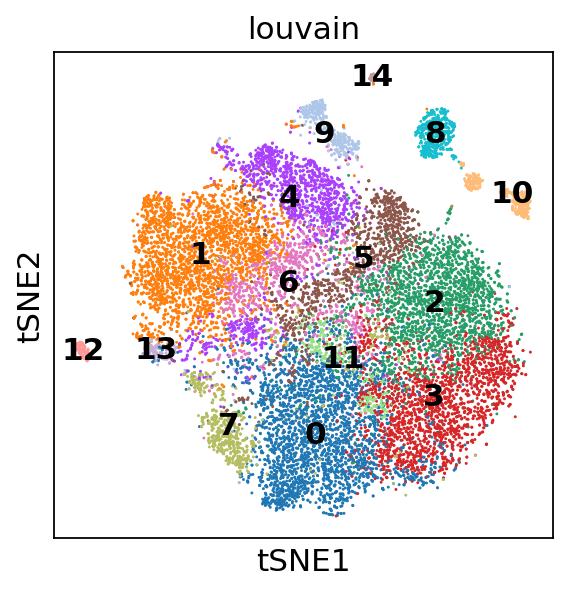

In [27]:
sc.tl.louvain(combined)
sc.pl.tsne(combined, color='louvain',legend_loc='on data')

### Find Marker Genes for TSNE Clusters

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


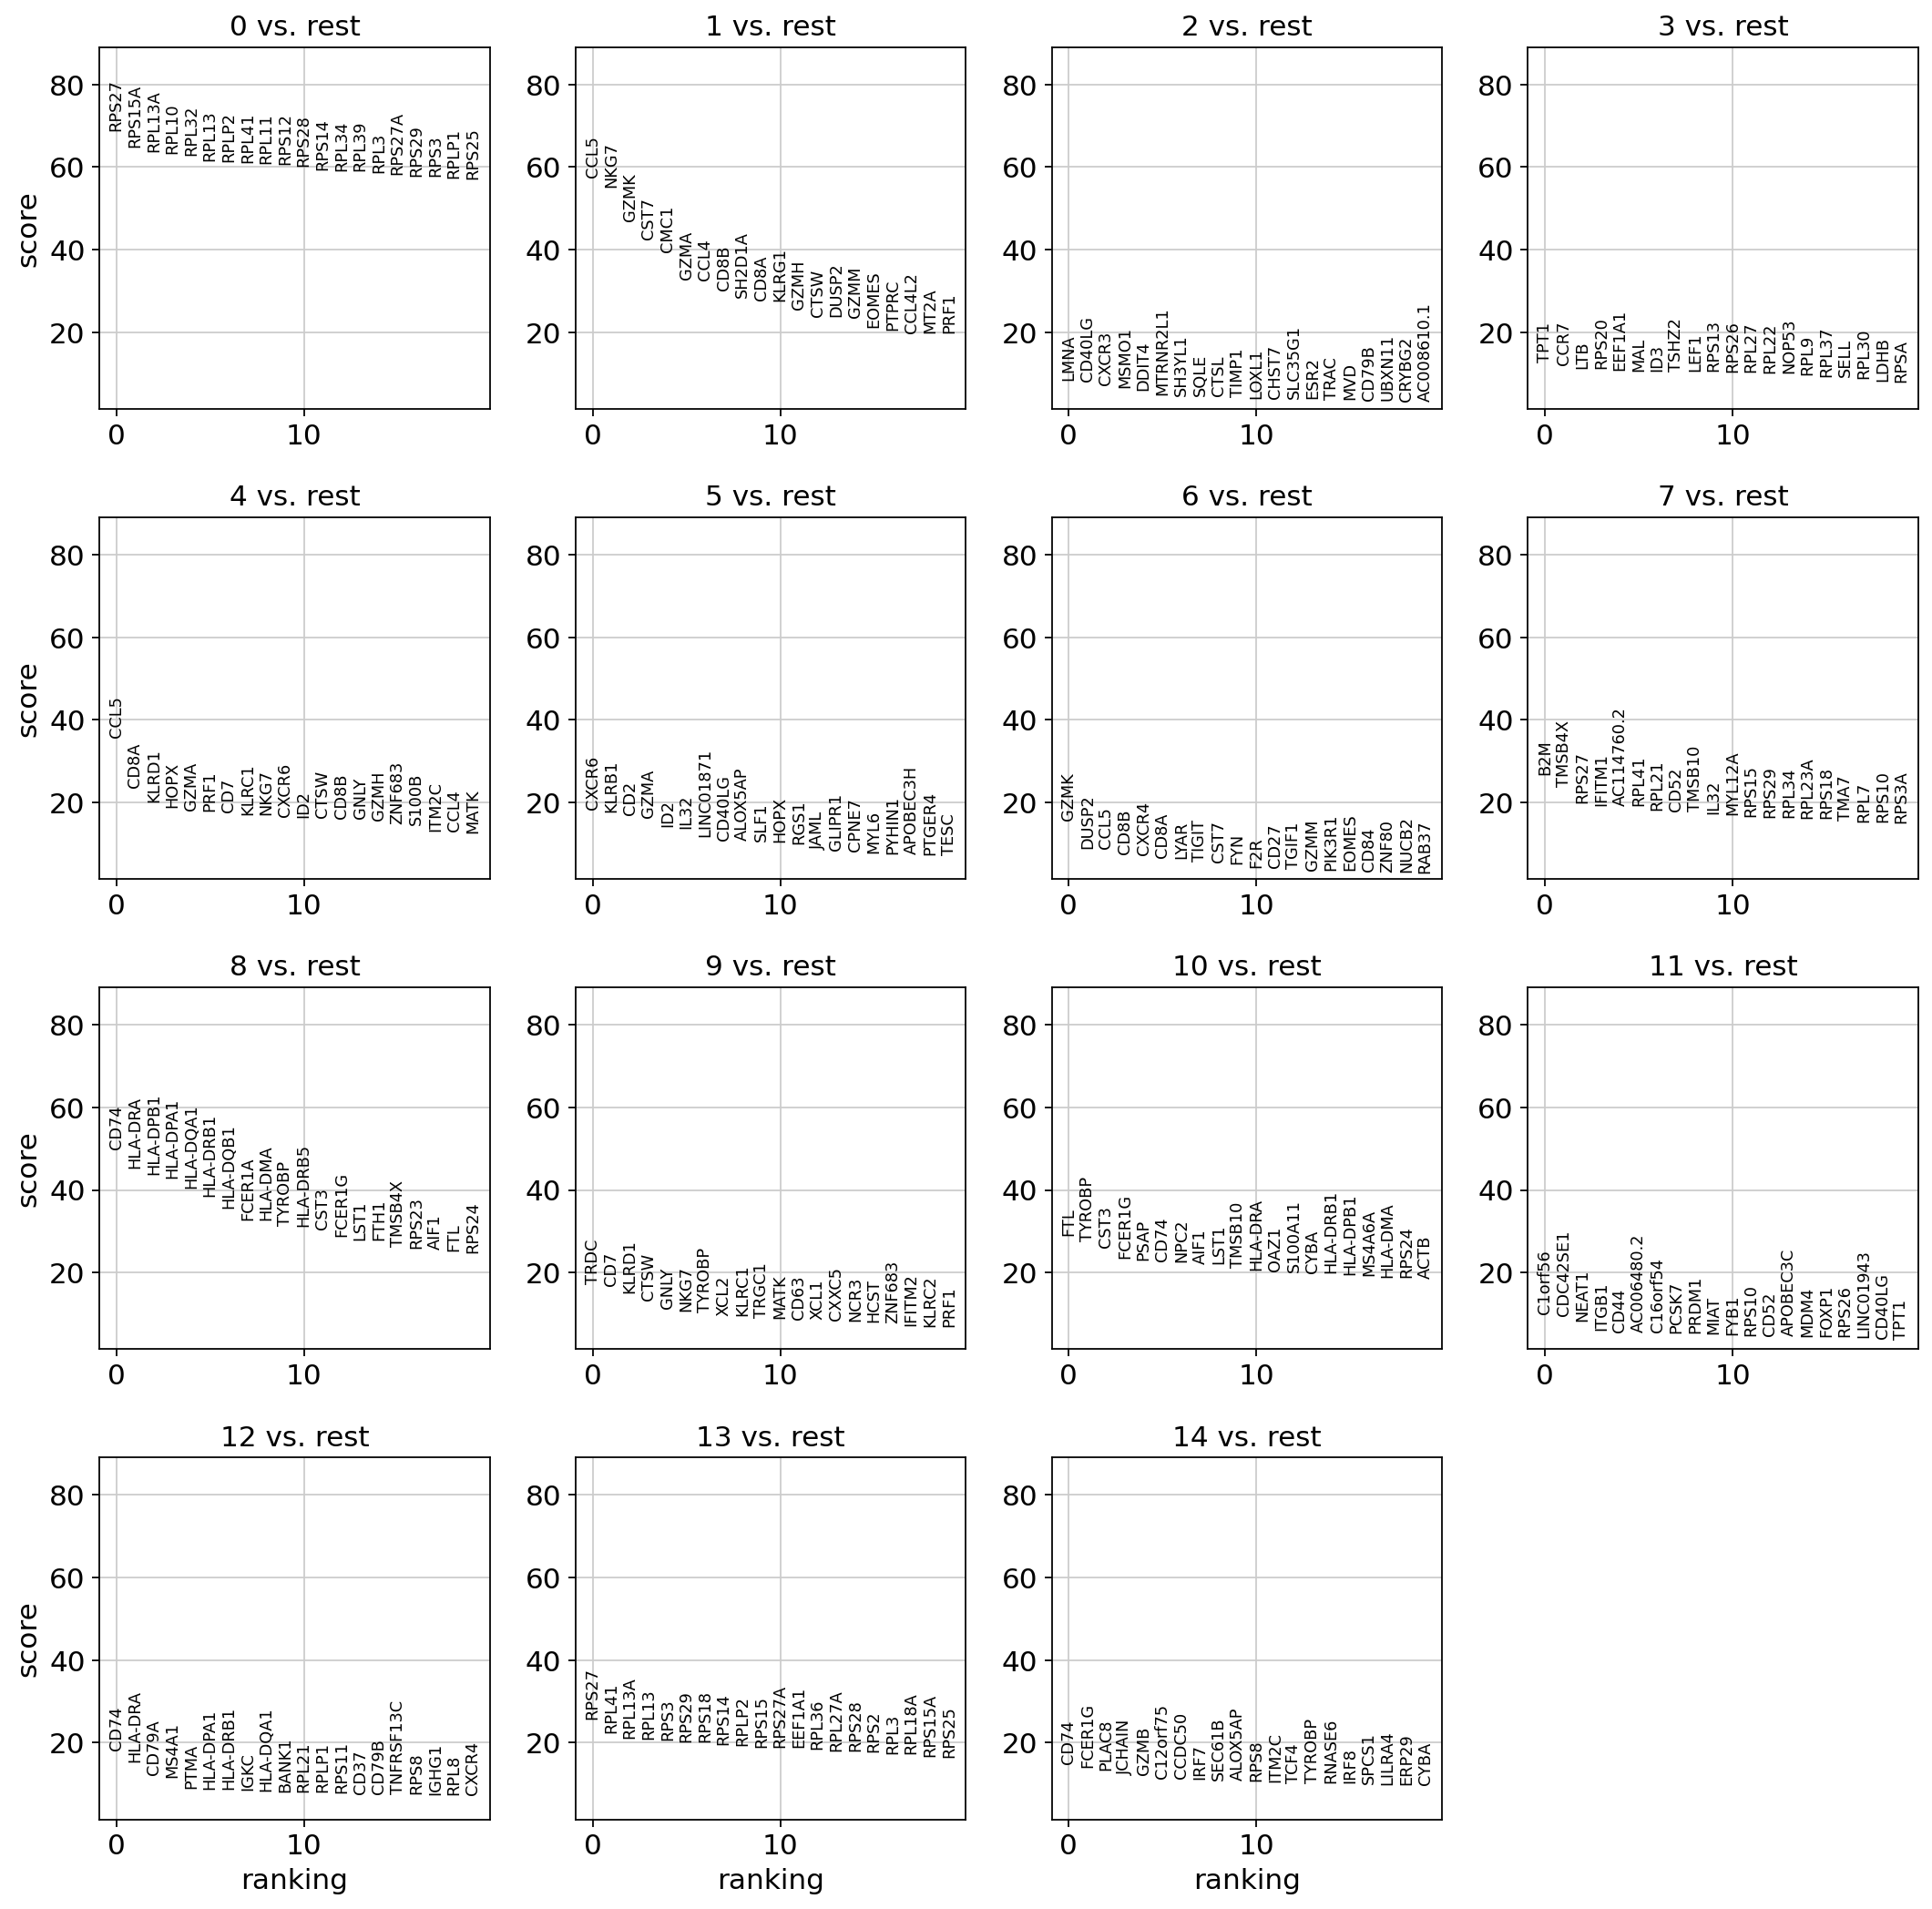

In [28]:
sc.tl.rank_genes_groups(combined, groupby='louvain', method='t-test')
sc.pl.rank_genes_groups(combined)

In [57]:
print("The tuples are ordered as (gene_names,log_fold_changes,adj_p_values)")
for i in range(15):
    print("Cluster {}:".format(i))
    print(tuple(zip((combined.uns['rank_genes_groups']['names'][i][j] for j in range(5)),
                    (combined.uns['rank_genes_groups']['logfoldchanges'][i][j] for j in range(5)),
                    (combined.uns['rank_genes_groups']['pvals_adj'][i][j] for j in range(5)))))

The tuples are ordered as (gene_names,log_fold_changes,adj_p_values)
Cluster 0:
(('RPS27', 30.346766, 0.0), ('CCL5', 7.867453, 0.0), ('LMNA', 1.7885866, 5.081993524297355e-16), ('TPT1', 1.7976742, 3.244251565430438e-34), ('CCL5', 6.6762333, 3.0924605731519423e-208))
Cluster 1:
(('RPS15A', 16.1986, 0.0), ('NKG7', 5.221773, 0.0), ('CD40LG', 0.77114415, 2.990803559740355e-15), ('CCR7', 1.3155574, 4.785285885999527e-31), ('CD8A', 2.4730473, 8.354307833659219e-105))
Cluster 2:
(('RPL13A', 18.850143, 0.0), ('GZMK', 3.618621, 0.0), ('CXCR3', 0.58589196, 9.319242439643282e-12), ('LTB', 1.0651747, 2.582021901741805e-27), ('KLRD1', 2.7914643, 2.0131971339151584e-78))
Cluster 3:
(('RPL10', 25.090937, 0.0), ('CST7', 2.8383162, 1.698807521787e-312), ('MSMO1', 0.73910296, 4.152291955154661e-10), ('RPS20', 1.281, 4.756638916424006e-27), ('HOPX', 1.9158756, 1.5594507587146735e-69))
Cluster 4:
(('RPL32', 16.07702, 0.0), ('CMC1', 5.0727825, 5.431241892549601e-272), ('DDIT4', 0.56918097, 2.95902187703533